In [1]:
import tensorflow as tf
import numpy as np

2021-11-23 07:41:17.120757: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [26]:
training_steps = 10000
batch_size = 64 
latent_dim = 10

In [27]:
(x_train, y_train), (x_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [28]:
x_train, x_test = np.array(x_train,np.float32), np.array(x_test,np.float32)

x_train, x_test = x_train/255., x_test/255.

x_train, x_test = np.expand_dims(x_train,axis=-1), np.expand_dims(x_test,axis=-1)

In [29]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape, Input, Lambda

conv1 = Conv2D(6,kernel_size=(5,5), strides=(1,1), activation = 'relu', input_shape=(28,28,1),padding='same')
maxpool1 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')
conv2 = Conv2D(16,kernel_size=(5,5), strides=(1,1), activation='relu',padding='valid')
maxpool2 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding = 'valid')
flat = Flatten()
dense = Dense(latent_dim+latent_dim)

dense_T = Dense(400,activation='relu')
reshape = Reshape((5,5,16))
upsample1 = UpSampling2D(size= (2,2))
conv1_T = Conv2DTranspose(16,kernel_size=(5,5), strides = (1,1), activation='relu',padding='valid')
upsample2=UpSampling2D(size=(2,2))
conv2_T = Conv2DTranspose(6,kernel_size=(5,5),strides=(1,1), activation='relu', padding='same')
output_T = Conv2DTranspose(1,kernel_size=(3,3),padding='same')

In [30]:
def vae(x,output_apply_sigmoid=False):
    _conv1 = conv1(x)
    _maxpool1 = maxpool1(_conv1)
    _conv2 = conv2(_maxpool1)
    _maxpool2 = maxpool2(_conv2)
    _flat = flat(_maxpool2)
    _dense = dense(_flat)
    
    mean, logvar = tf.split(_dense, num_or_size_splits = 2, axis=1)
    
    epsilon = tf.random.normal(shape=tf.shape(mean))
    z= mean + tf.exp(0.5*logvar)*epsilon
    
    _dense_T = dense_T(z)
    _reshape = reshape(_dense_T)
    _upsample1 = upsample1(_reshape)
    _conv1_T = conv1_T(_upsample1)
    _upsample2 = upsample2(_conv1_T)
    _conv2_T = conv2_T(_upsample2)
    logits = output_T(_conv2_T)
    
    if output_apply_sigmoid:
        probs = tf.sigmoid(logits)
        return probs, mean, logvar
    return logits, mean, logvar

In [31]:
input_img = tf.keras.Input(shape=(28,28,1))
output_img, mean, logvar = vae(input_img)
model = tf.keras.Model(input_img, [output_img, mean, logvar], name = 'encoder')
model.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 6)    156         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 6)    0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 10, 10, 16)   2416        max_pooling2d_2[0][0]            
____________________________________________________________________________________________

In [32]:
def compute_loss(x,x_generated, mean, logvar):
    reconstruction_error = tf.reduce_sum(tf.square(x-x_generated), axis=[1,2,3])
    KL_divergence = 0.5*tf.reduce_sum(tf.exp(logvar)-logvar+tf.square(mean)-1, axis=1)
    vae_loss = tf.reduce_mean(reconstruction_error+KL_divergence)
    
    return vae_loss

In [33]:
import time

train_data = tf.data.Dataset.from_tensor_slices(x_train)
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

optimizer = tf.optimizers.Adam()

start_time = time.time()
for step, batch_x in enumerate(train_data.take(training_steps),1):
    with tf.GradientTape() as tape:
        x_out, z_mean, z_logvar = model(batch_x)
        loss = compute_loss(batch_x, x_out, z_mean, z_logvar)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    if step%100 ==0:
        end_time = time.time()
        
        x_out, z_mean, z_logvar = model(x_test)
        loss = compute_loss(x_test, x_out, z_mean, z_logvar)
        print('Step: {}, Test set loss: {}, timpe elapse for current epoch: {}'.format(step, loss, end_time-start_time))
        

Step: 100, Test set loss: 46.18888473510742, timpe elapse for current epoch: 1.2879917621612549
Step: 200, Test set loss: 38.56757354736328, timpe elapse for current epoch: 2.37031626701355
Step: 300, Test set loss: 35.23427200317383, timpe elapse for current epoch: 3.6407134532928467
Step: 400, Test set loss: 33.14338684082031, timpe elapse for current epoch: 4.691702365875244
Step: 500, Test set loss: 31.723190307617188, timpe elapse for current epoch: 5.728875637054443
Step: 600, Test set loss: 31.363882064819336, timpe elapse for current epoch: 6.706120252609253
Step: 700, Test set loss: 30.3768367767334, timpe elapse for current epoch: 8.10715627670288
Step: 800, Test set loss: 30.090789794921875, timpe elapse for current epoch: 9.30304503440857
Step: 900, Test set loss: 29.77467155456543, timpe elapse for current epoch: 10.434165239334106
Step: 1000, Test set loss: 29.382925033569336, timpe elapse for current epoch: 11.517999410629272
Step: 1100, Test set loss: 29.2677059173584, 

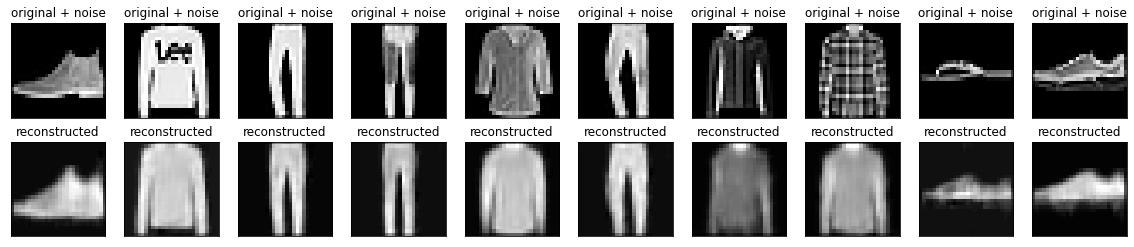

In [34]:
import matplotlib.pyplot as plt

n=10 

decoded_imgs,_,_ = model(x_test)

plt.figure(figsize=(20,4))
for i in range(n):
    
    ax = plt.subplot(2,n,i+1)
    plt.title('original + noise')
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    bx = plt.subplot(2,n,i+n+1)
    plt.title('reconstructed')
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
    
plt.show()

In [35]:
def vae_decoder(z):
    _dense_T = dense_T(z)
    _reshape = reshape(_dense_T)
    _upsample1 = upsample1(_reshape)
    _conv1_T = conv1_T(_upsample1)
    _upsample2 = upsample2(_conv1_T)
    _conv2_T = conv2_T(_upsample2)
    logits = output_T(_conv2_T)
    
    return logits

In [36]:
z =np.random.normal(size = (10,10))
print(z.shape)

recon = vae_decoder(z)
print(recon.shape)

(10, 10)


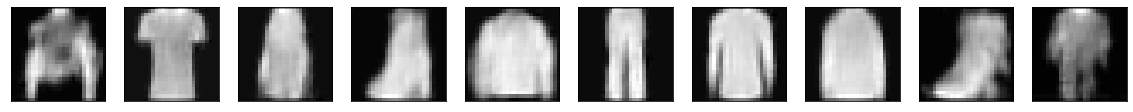

In [37]:
plt.figure(figsize=(20,4))
for i in range(10):
    ax = plt.subplot(2,n,i+1)
    plt.imshow(tf.squeeze(recon[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()